<h1>
<center>Dynamic Graph Convolution Neural Networks </center>
</h1>

## Generals 

<font size="3"> 
Packages import and system configurations. 
</font>

In [1]:
#Data
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
from numpy import *
#Graph Counstruction
import torch
from torch_geometric_temporal.signal import StaticGraphTemporalSignal,DynamicGraphTemporalSignal
import torch
import torchmetrics

import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN2, DCRNN, TGCN2, TGCN,  GConvGRU, GConvLSTM, GCLSTM
from torch.nn import Linear
from torch.nn import ReLU
import matplotlib.pyplot as plt


<font size="3"> 
Define necessary paths. 
</font>

In [2]:
data_intermediate_path ='io/input/data_intermediate/'
export_path = 'io/output/exports/'
test_path = 'io/input/base_data/test.csv'

train_node_features_path = data_intermediate_path + 'node_features/train/'
train_node_labels_path = data_intermediate_path + 'node_labels/train/'
train_edges_path = data_intermediate_path + 'edges/train/'
train_edge_weights_path = data_intermediate_path + 'edge_weights/train/'

val_node_labels_path = data_intermediate_path + 'node_labels/val/'
val_node_features_path = data_intermediate_path + 'node_features/val/'
val_edges_path = data_intermediate_path + 'edges/val/'
val_edge_weights_path = data_intermediate_path + 'edge_weights/val/'

test_node_labels_path = data_intermediate_path + 'node_labels/test/'
test_node_features_path = data_intermediate_path + 'node_features/test/'
test_edges_path = data_intermediate_path + 'edges/test/'
test_edge_weights_path = data_intermediate_path + 'edge_weights/test/'

predictions_path = export_path + 'predictions/'
metrics_plot_path = export_path + 'metrics_plots/'

## Core Functionality

<font size="3"> 
Load numpy arrays on chunks. 
</font>

In [3]:
def load_object(path):
    num_chunks = len([f for f in os.listdir(path) if f.startswith('chunk_') and f.endswith('.npy')])
    # Load array from chunks
    chunks = []
    for i in range(num_chunks):
        filename = f"{path}chunk_{i}.npy"
        chunk = np.load(filename,allow_pickle=True)
        chunks.append(chunk)
    arr_reconstructed = np.concatenate(chunks, axis=0)
    return arr_reconstructed

<font size="3"> 
Load all graph information and print shapes
</font>

In [4]:
train_node_features = load_object(train_node_features_path)
train_node_labels = load_object(train_node_labels_path)
train_edges = load_object(train_edges_path)
train_edge_weights = load_object(train_edge_weights_path)

val_node_features = load_object(val_node_features_path)
val_node_labels = load_object(val_node_labels_path)
val_edges = load_object(val_edges_path) ##
val_edge_weights = load_object(val_edge_weights_path) ##

test_node_features = load_object(test_node_features_path)
test_node_labels = load_object(test_node_labels_path)
test_edges = load_object(test_edges_path)
test_edge_weights = load_object(test_edge_weights_path)

print('Train Node Features Train',train_node_features.shape)
print('Train Node Labels Train',train_node_labels.shape)
print('Train Edges Shape',train_edges.shape)
print('Train Edges Weights Shapes',train_edge_weights.shape)
print('\n')
print('Validation Node Features Train',val_node_features.shape)
print('Validation Node Labels Train',val_node_labels.shape)
print('Validation Edges Shape',val_edges.shape)
print('Validation Edges Weights Shapes',val_edge_weights.shape)
print('\n')
print('Test Node Features Train',test_node_features.shape)
print('Test Node Labels Train',test_node_labels.shape)
print('Test Edges Shape',test_edges.shape)
print('Test Edges Weights Shapes',test_edge_weights.shape)

Train Node Features Train (5370, 8, 21, 1)
Train Node Labels Train (5370, 8, 1)
Train Edges Shape (5370, 2, 64)
Train Edges Weights Shapes (5370, 64)


Validation Node Features Train (2005, 8, 21, 1)
Validation Node Labels Train (2005, 8, 1)
Validation Edges Shape (2005, 2, 64)
Validation Edges Weights Shapes (2005, 64)


Test Node Features Train (622, 8, 21, 1)
Test Node Labels Train (622, 8, 1)
Test Edges Shape (622, 2, 64)
Test Edges Weights Shapes (622, 64)


## Convert Graph info to loaders

<font size="3"> 
Zero edge weights according thresholds and exclude self edges
<br>
<br>
This is used to optimize the edges according to our problem
</font>

In [5]:
edge_threshold = 0.2

# train_edge_weights[train_edge_weights == 1] = 0 #We exclude self edges
train_edge_weights[train_edge_weights < edge_threshold] = 0
# train_edge_weights = train_edge_weights * train_edge_weights

# val_edge_weights[val_edge_weights == 1] = 0 #We exclude self edges
val_edge_weights[val_edge_weights < edge_threshold] = 0
# val_edge_weights = val_edge_weights * val_edge_weights

# test_edge_weights[test_edge_weights == 1] = 0 #We exclude self edges
test_edge_weights[test_edge_weights < edge_threshold] = 0
# test_edge_weights = test_edge_weights * test_edge_weights

<font size="3"> 
This is a costum loader that we use to have at the same loader, features, targets edges and edge-weigths
</font>

In [6]:
def dynamic_data_loader(graph,batch_size):
    features = np.array(graph.features)
    targets = np.array(graph.targets)
    edges = np.array(graph.edge_indices)
    edge_attr = np.array(graph.edge_weights)
    features_tensor = torch.from_numpy(features).type(torch.FloatTensor)
    targets_tensor = torch.from_numpy(targets).type(torch.FloatTensor)
    edges_tensor = torch.from_numpy(edges).type(torch.LongTensor)
    edge_attr_tensor = torch.from_numpy(edge_attr).type(torch.FloatTensor)
    dataset_new = torch.utils.data.TensorDataset(features_tensor, edges_tensor, edge_attr_tensor, targets_tensor)
    
    class CustomDataLoader(torch.utils.data.DataLoader):
        def __init__(self, dataset, batch_size, drop_last):
            super().__init__(dataset, batch_size=batch_size, drop_last=drop_last)

        def collate_fn(self, data):
            features, edges, edge_attr, targets = zip(*data)
            batch_features = torch.stack(features)
            batch_edges = torch.stack(edges)
            batch_edge_attr = torch.stack(edge_attr)
            batch_targets = torch.stack(targets)
            return batch_features, batch_edges, batch_edge_attr, batch_targets
    graph_loader = CustomDataLoader(dataset_new, batch_size=batch_size, drop_last=False)
    return graph_loader

<font size="3"> 
We use this function to apply our loader
</font

In [7]:
def graph_data_loader(batch_size,train_edges,train_edge_weights,train_node_features,train_node_labels,
                      test_edges,test_edge_weights,test_node_features,test_node_labels):

    graph_train = DynamicGraphTemporalSignal(edge_indices=train_edges,edge_weights=train_edge_weights,
                                   features=train_node_features,targets=train_node_labels)


    graph_test = DynamicGraphTemporalSignal(edge_indices=test_edges,edge_weights=test_edge_weights,
                                   features=test_node_features,targets=test_node_labels)

    
    train_loader = dynamic_data_loader(graph_train,batch_size)
    test_loader = dynamic_data_loader(graph_test,batch_size)
    return train_loader,test_loader

## Graph Neural Networks Model

<font size="3"> 
Graph neural networks architecture 
</font

In [8]:
class TemporalGNN_RNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size, gcn, filter_size):
        super(TemporalGNN_RNN, self).__init__()
        
        if gcn == 'A3TGCN2':
            self.tgnn = A3TGCN2(in_channels=node_features, periods=periods, out_channels=64, batch_size=batch_size, cached=True)
        elif gcn == 'DCRNN':
            self.tgnn = DCRNN(in_channels=node_features, out_channels=64, K=periods)
        elif gcn == 'TGCN2':
            self.tgnn = TGCN2(in_channels=node_features, out_channels=64, batch_size=batch_size, cached=True)
        elif gcn == 'TGCN':
            self.tgnn = TGCN(in_channels=node_features, out_channels=64, cached=True)
        elif gcn == 'GConvGRU':
            self.tgnn = GConvGRU(in_channels=node_features, out_channels=64, K=filter_size)

        self.hidden2 = Linear(64, 32)        
        self.act2 = ReLU()
           
        self.hidden3 = Linear(32, 16)
        self.act3 = ReLU()        

        self.linear = torch.nn.Linear(16, periods)       

    def forward(self, x, edge_index, edge_weight):
        h = self.tgnn(x, edge_index, edge_weight)
        h = F.relu(h)

        h = self.hidden2(h)
        h = self.act2(h)
        
        h = self.hidden3(h)
        h = self.act3(h)
        
        out = self.linear(h) 
        return out

In [9]:
class TemporalGNN_LSTM(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size, gcn, filter_size):
        super(TemporalGNN_LSTM, self).__init__()
        
        if gcn == 'GConvLSTM':
            self.tgnn = GConvLSTM(in_channels=node_features, out_channels=64, K=filter_size)
        elif gcn == 'GCLSTM':
            self.tgnn = GCLSTM(in_channels=node_features, out_channels=64, K=filter_size)

        self.hidden2 = Linear(64, 32)        
        self.act2 = ReLU()
           
        self.hidden3 = Linear(32, 16)
        self.act3 = ReLU()        

        self.linear = torch.nn.Linear(16, periods)       

    def forward(self, x, edge_index, edge_weight):
        h, _ = self.tgnn(x, edge_index, edge_weight)
        h = F.relu(h)

        h = self.hidden2(h)
        h = self.act2(h)
        
        h = self.hidden3(h)
        h = self.act3(h)
        
        out = self.linear(h) 
        return out

<font size="3"> 
Use the model to calculate metrics while predict using a test data loader
</font

In [10]:
def calculate_evalaution_metrics(model,loader,loss_fn, squeeze_input):
    model.eval()
    predictions = []
    ground_truth = []

    loss_list, mae_list ,r2_list, rmse_list = [], [], [], []
    for snapsot in loader:
        if squeeze_input:
            snapsot[0] = snapsot[0].squeeze(0).squeeze(-1)
            snapsot[3] = snapsot[3].squeeze(0)
        
        y_hat = model(snapsot[0], snapsot[1][-1], snapsot[2][-1])
        y_true = y_hat
        y_pred = snapsot[3]
        
        y_pred_ar = y_hat.detach().numpy()
        for y in y_pred_ar:
            predictions.append(y.reshape(8))
        
        y_true_ar = y_true.detach().numpy()
        for y in y_true_ar:
            ground_truth.append(y.reshape(8))

        loss = loss_fn(y_hat, snapsot[3])
        loss_list.append(loss.item())
        
        mae = torch.mean(torch.abs(y_pred - y_true))
        mae_list.append(mae.detach().numpy())
        
        r2 = torchmetrics.functional.r2_score(y_pred.view(-1), y_true.view(-1))
        r2_list.append(r2.detach().numpy())

        rmse = torch.sqrt(torch.mean(torch.pow(y_pred - y_true, 2)))
        rmse_list.append(rmse.detach().numpy())
        
    loss = sum(loss_list) / len(loss_list)
    mae = sum(mae_list) / len(mae_list)
    r2 = sum(r2_list) / len(r2_list)
    rmse = sum(rmse_list) / len(rmse_list)
    return loss,mae,r2,rmse,predictions,ground_truth

In [22]:
def y_pivot(ground_trouth,predictions,nodes,test_path,predictions_path,gcn):
    testset = pd.read_csv(test_path,index_col=0)
    dates = testset.index.tolist()
    dates = sorted(set(dates))
    pivot_true = pd.DataFrame(np.vstack(ground_trouth), index=dates, columns=nodes)
    pivot_pred = pd.DataFrame(np.vstack(predictions), index=dates, columns=nodes)
    pivot_true.to_csv(predictions_path+gcn+'_ground_truth.csv')
    pivot_pred.to_csv(predictions_path+gcn+'_predictions.csv')
    return pivot_pred,pivot_true

## Training

In [12]:
def model_training(node_features,batch_size,lr,epochs,train_loader,val_loader,loss_fn,
                   gcn, filter_size, squeeze_input=False, arch='RNN'):
    if arch == 'RNN':
        model = TemporalGNN_RNN(node_features=node_features, periods=1, batch_size=batch_size,
                            gcn=gcn, filter_size=filter_size)
    elif arch == 'LSTM':
        model = TemporalGNN_LSTM(node_features=node_features, periods=1, batch_size=batch_size,
                                gcn=gcn, filter_size=filter_size)
    
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    model.train()
    train_loss_ls,train_mae_ls,train_r2_ls,train_rmse_ls = [],[],[],[]
    val_loss_ls,val_mae_ls,val_r2_ls,val_rmse_ls = [],[],[],[]
    for epoch in range(epochs):
        loss_list, mae_list ,r2_list, rmse_list = [], [], [], []
        step = 0
        loss = 0
        for snapsot in tqdm(train_loader):
            if squeeze_input:
                snapsot[0] = snapsot[0].squeeze(0).squeeze(-1)
                snapsot[3] = snapsot[3].squeeze(0)
                
            y_hat = model(snapsot[0], snapsot[1][0], snapsot[2][0])
            loss = loss_fn(y_hat, snapsot[3])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            step= step+ 1
            loss_list.append(loss.item())
            # (!) ---> All the above code is for metrics calculation
            y_true = y_hat
            y_pred = snapsot[3]
            mae = torch.mean(torch.abs(y_pred - y_true))
            mae_list.append(mae.detach().numpy())
            r2 = torchmetrics.functional.r2_score(y_pred.view(-1), y_true.view(-1))
            r2_list.append(r2.detach().numpy())
            rmse = torch.sqrt(torch.mean(torch.pow(y_pred - y_true, 2)))
            rmse_list.append(rmse.detach().numpy())

        train_loss = sum(loss_list) / len(loss_list)
        train_mae = sum(mae_list) / len(mae_list)
        train_r2 = sum(r2_list) / len(r2_list)
        train_rmse = sum(rmse_list) / len(rmse_list)
        val_loss,val_mae,val_r2,val_rmse,predictions,ground_truth = calculate_evalaution_metrics(model,val_loader,loss_fn, squeeze_input)
        print("Epoch {}, Train || MSE: {:.7f}, MAE: {:.7f}, R2: {:.7f}, RMSE: {:.7f}".format(epoch+1,train_loss,train_mae,train_r2,train_rmse))
        print("Epoch {}, Evaluation || MSE: {:.7f}, MAE: {:.7f}, R2: {:.7f}, RMSE: {:.7f}".format(epoch+1,val_loss,val_mae,val_r2,val_rmse))
        train_loss_ls.append(train_loss)
        train_mae_ls.append(train_mae)
        train_r2_ls.append(train_r2)
        train_rmse_ls.append(train_rmse)
        val_loss_ls.append(val_loss)
        val_mae_ls.append(val_mae)
        val_r2_ls.append(val_r2)
        val_rmse_ls.append(val_rmse)
    metrics = {'train_loss_ls': train_loss_ls,'train_mae_ls': train_mae_ls,'train_r2_ls': train_r2_ls,
               'train_rmse_ls': train_rmse_ls,'eval_loss_ls': val_loss_ls,'eval_mae_ls': val_mae_ls,
               'eval_r2_ls': val_r2_ls,'eval_rmse_ls': val_rmse_ls}
    return model,metrics   

## Plot results

In [13]:
def smooth_curve(points, factor=0):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [14]:
def plot_single_metric(metric,metric_label,set_label,metrics_plot_path,gcn):
    smooth_metric = smooth_curve(metric)
    plt.plot(range(1, len(smooth_metric) + 1), smooth_metric,label=set_label)
    plt.title('Loss during Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_label)
    plt.legend()
    plt.savefig(metrics_plot_path+gcn+'_'+set_label+'_'+metric_label+'.pdf')
    plt.show()

In [15]:
def plot_all_metrics_train_val(metrics,evaluation_mode,metrics_plot_path,gcn):
    smooth_mse_train = smooth_curve(metrics['train_loss_ls'])
    smooth_mse_val = smooth_curve(metrics['eval_loss_ls'])
    smooth_mae_train = smooth_curve(metrics['train_mae_ls'])
    smooth_mae_val = smooth_curve(metrics['eval_mae_ls'])
    smooth_r2_train = smooth_curve(metrics['train_r2_ls'])
    smooth_r2_val = smooth_curve(metrics['eval_r2_ls'])
    smooth_rmse_train = smooth_curve(metrics['train_rmse_ls'])
    smooth_rmse_val = smooth_curve(metrics['eval_rmse_ls'])

    fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(12, 8))
    # Plot the first metric on the top-left subplot
    axs[0, 0].plot(range(1, len(smooth_mse_train) + 1), smooth_mse_train,label='Train')
    axs[0, 0].plot(range(1, len(smooth_mse_val) + 1), smooth_mse_val,label=evaluation_mode)
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('MSE')
    axs[0, 0].set_title('MSE')
    axs[0, 0].legend()
    # Plot the second metric on the top-right subplot
    axs[0, 1].plot(range(1, len(smooth_mae_train) + 1), smooth_mae_train,label='Train')
    axs[0, 1].plot(range(1, len(smooth_mae_val) + 1), smooth_mae_val,label=evaluation_mode)
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('MAE')
    axs[0, 1].set_title('MAE')
    axs[0, 1].legend()
    # Plot the third metric on the bottom-left subplot
    axs[1, 0].plot(range(1, len(smooth_r2_train) + 1), smooth_r2_train,label='Train')
    axs[1, 0].plot(range(1, len(smooth_r2_val) + 1), smooth_r2_val,label=evaluation_mode)
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('R2')
    axs[1, 0].set_title('R2')
    axs[1, 0].legend()
    # Plot the fourth metric on the bottom-right subplot
    axs[1, 1].plot(range(1, len(smooth_rmse_train) + 1), smooth_rmse_train,label='Train')
    axs[1, 1].plot(range(1, len(smooth_rmse_val) + 1), smooth_rmse_val,label=evaluation_mode)
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('RMSE')
    axs[1, 1].set_title('RMSE')
    axs[1, 1].legend()
    # Adjust the spacing between subplots
    plt.tight_layout()
    # Show the plot
    plt.savefig(metrics_plot_path+gcn+'_'+evaluation_mode+'_Metrics'+'.pdf')
    plt.show()

## Pipeline Execution

### Global Envariables

In [16]:
nodes = ['ADA','BNB','BTC','DASH','ETH','LINK','LTC','XRP']
node_features = train_node_features.shape[2]
loss_fn = torch.nn.MSELoss()
gcn_list = ['A3TGCN2', 'DCRNN', 'TGCN', 'TGCN2', 'GConvGRU', 'GConvLSTM', 'GCLSTM']
recurent_type_list = ['RNN','LSTM']
gcn = gcn_list[3] #TGCN2
recurent_type = recurent_type_list[0] #RNN
squeeze_input = True
filter_size = 3
batch_size = 8
recurent_steps = batch_size/2
lr = 0.001

### Hyperparameter Optimization using Validation set

In [17]:
epochs = 4
train_loader,val_loader = graph_data_loader(batch_size, train_edges, train_edge_weights, train_node_features, train_node_labels,
                                             val_edges, val_edge_weights, val_node_features, val_node_labels)

print('Graph Convolutional Network: ' + gcn)
model,metrics_val = model_training(node_features, recurent_steps, lr, epochs, train_loader, val_loader, loss_fn, 
                                   gcn, filter_size, squeeze_input, recurent_type)

Graph Convolutional Network: TGCN2


100%|████████████████████████████████████████| 672/672 [00:01<00:00, 506.90it/s]


Epoch 1, Train || MSE: 90276609.7834821, MAE: 2715.1043527, R2: -516570599.6190476, RMSE: 7632.2983631
Epoch 1, Evaluation || MSE: 45954143.9940239, MAE: 2240.0649900, R2: -1.5904919, RMSE: 5795.9750996


100%|████████████████████████████████████████| 672/672 [00:01<00:00, 570.65it/s]


Epoch 2, Train || MSE: 33187532.4522754, MAE: 1351.4227121, R2: 0.3180010, RMSE: 3769.1056548
Epoch 2, Evaluation || MSE: 13899865.2198083, MAE: 1337.0846614, R2: 0.8765856, RMSE: 3481.8680279


100%|████████████████████████████████████████| 672/672 [00:01<00:00, 552.16it/s]


Epoch 3, Train || MSE: 6794916.1827489, MAE: 519.5105097, R2: 0.9582191, RMSE: 1439.3175223
Epoch 3, Evaluation || MSE: 44937711.1752988, MAE: 2164.4265438, R2: 0.7965722, RMSE: 5818.2440239


100%|████████████████████████████████████████| 672/672 [00:01<00:00, 539.16it/s]


Epoch 4, Train || MSE: 1469735.0423483, MAE: 249.1169085, R2: 0.9918909, RMSE: 674.7043806
Epoch 4, Evaluation || MSE: 21326779.1243775, MAE: 1528.9372510, R2: 0.8619329, RMSE: 4007.7124004


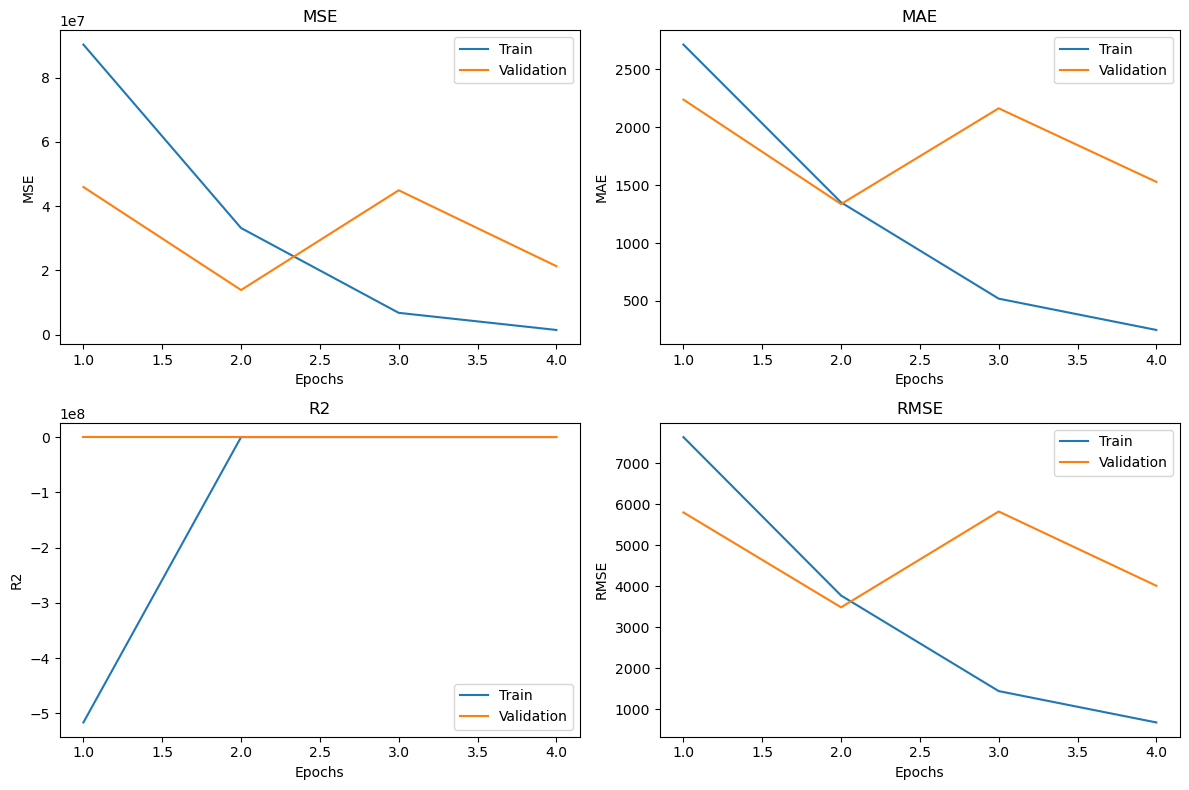

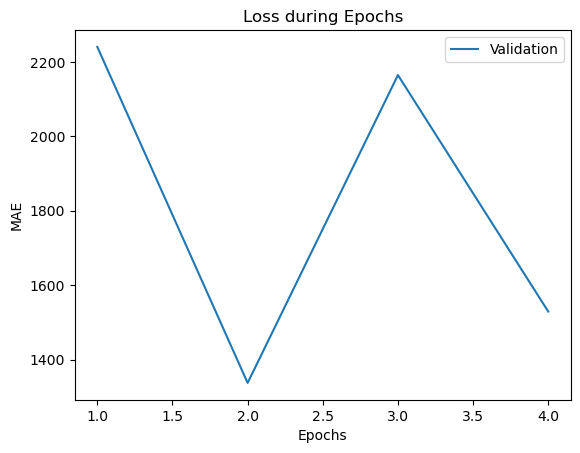

In [18]:
plot_all_metrics_train_val(metrics_val,'Validation',metrics_plot_path,gcn)
plot_single_metric(metrics_val['eval_mae_ls'],'MAE','Validation',metrics_plot_path,gcn)

### Model's Training

In [19]:
train_edges_f = np.concatenate((train_edges, val_edges), axis=0)
train_edge_weights_f = np.concatenate((train_edge_weights, val_edge_weights), axis=0)
train_node_features_f = np.concatenate((train_node_features, val_node_features), axis=0)
train_node_labels_f = np.concatenate((train_node_labels, val_node_labels), axis=0)
epochs = 4

train_loader,test_loader = graph_data_loader(batch_size, train_edges_f, train_edge_weights_f, train_node_features_f,
                                train_node_labels_f, test_edges, test_edge_weights, test_node_features, test_node_labels)

print('Graph Convolutional Network: ' + gcn)
model, metrics_test = model_training(node_features, recurent_steps, lr, epochs, train_loader, test_loader, loss_fn,
                                     gcn, filter_size, squeeze_input, recurent_type)


Graph Convolutional Network: TGCN2


100%|████████████████████████████████████████| 922/922 [00:01<00:00, 538.21it/s]


Epoch 1, Train || MSE: 96579329.6746204, MAE: 2849.3191432, R2: -3566721881.4056401, RMSE: 8010.4945770
Epoch 1, Evaluation || MSE: 14662589.4294872, MAE: 1492.8192107, R2: -0.3797512, RMSE: 3687.1854968


100%|████████████████████████████████████████| 922/922 [00:01<00:00, 462.57it/s]


Epoch 2, Train || MSE: 34249344.1470146, MAE: 1345.9167570, R2: 0.1197718, RMSE: 3755.6144252
Epoch 2, Evaluation || MSE: 2247647.9678611, MAE: 474.9765625, R2: 0.9298070, RMSE: 1189.4438101


100%|████████████████████████████████████████| 922/922 [00:02<00:00, 460.88it/s]


Epoch 3, Train || MSE: 7382148.0335440, MAE: 522.1871611, R2: 0.9477729, RMSE: 1444.9422451
Epoch 3, Evaluation || MSE: 1862640.2769306, MAE: 492.4976963, R2: 0.9450877, RMSE: 1159.5596955


100%|████████████████████████████████████████| 922/922 [00:01<00:00, 521.92it/s]


Epoch 4, Train || MSE: 4731782.2034181, MAE: 407.6862120, R2: 0.9712299, RMSE: 1124.9303823
Epoch 4, Evaluation || MSE: 2718377.2485477, MAE: 566.5468750, R2: 0.9094909, RMSE: 1381.3693910


### Evaluation on Test set

In [23]:
mse,mae,r2,rmse,predictions,ground_truth = calculate_evalaution_metrics(model, test_loader, loss_fn, squeeze_input)
print("Evaluation on Test || MSE: {:.7f}, MAE: {:.7f}, R2: {:.7f}, RMSE: {:.7f}".format(mse,mae,r2,rmse))
pivot_pred,pivot_true = y_pivot(ground_truth,predictions,nodes,test_path,predictions_path,gcn)

Evaluation on Test || MSE: 2718377.2485477, MAE: 566.5468750, R2: 0.9094909, RMSE: 1381.3693910


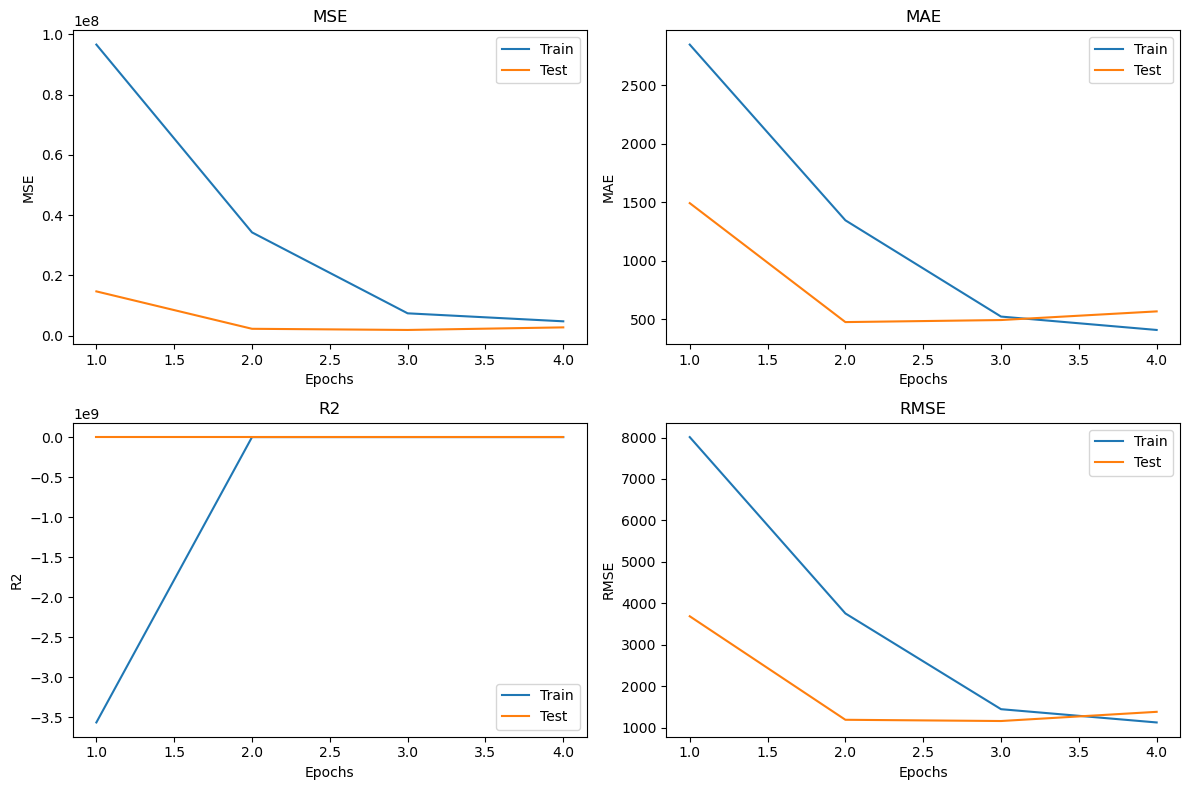

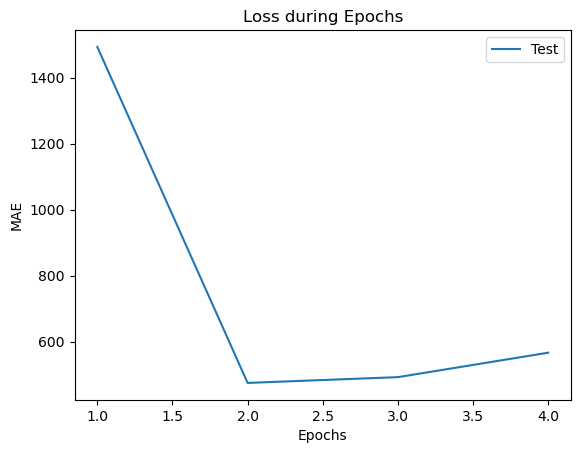

In [21]:
plot_all_metrics_train_val(metrics_test,'Test',metrics_plot_path,gcn)
plot_single_metric(metrics_test['eval_mae_ls'],'MAE','Test',metrics_plot_path,gcn)